In [1]:
import random
import tensorflow as tf
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from math import log2, ceil
from proglearn.forest import LifelongClassificationForest
from proglearn.sims import generate_spirals

# Simulation Data Generation


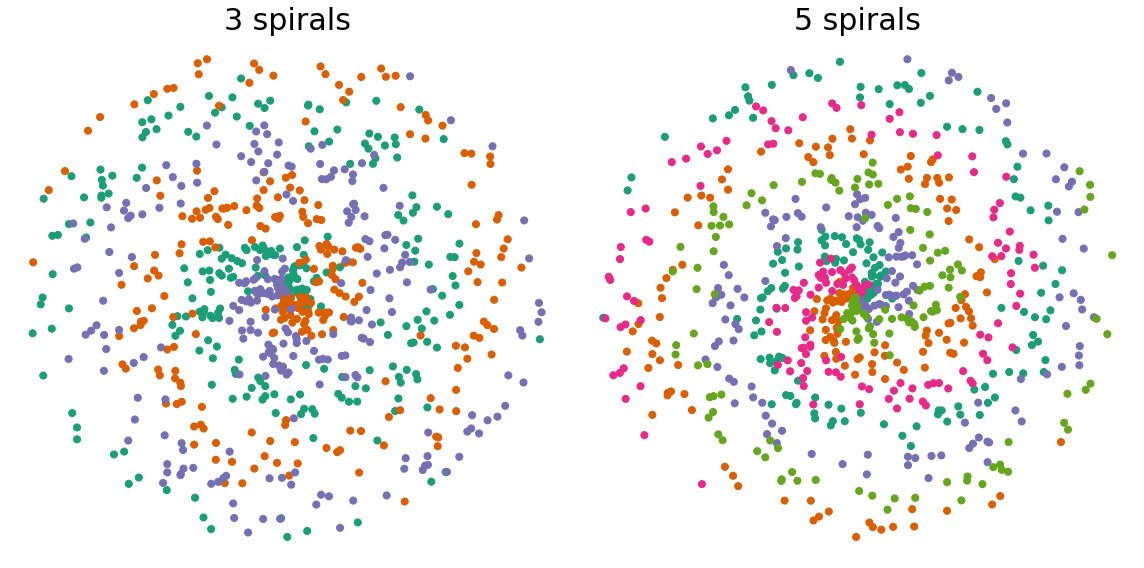

In [2]:
spiral3, y_spiral3 = generate_spirals(750, 3, noise=0.8)
spiral5, y_spiral5 = generate_spirals(750, 5, noise=0.4)

colors = sns.color_palette('Dark2', n_colors=5)

fig, ax = plt.subplots(1,2, figsize=(16,8))

clr = [colors[i] for i in y_spiral3]
ax[0].scatter(spiral3[:, 0], spiral3[:, 1], c=clr, s=50)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('3 spirals', fontsize=30)
ax[0].axis('off')

clr = [colors[i] for i in y_spiral5]
ax[1].scatter(spiral5[:, 0], spiral5[:, 1], c=clr, s=50)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('5 spirals', fontsize=30)
ax[1].axis('off')

plt.tight_layout()

# Experiment definition

In [3]:
def experiment(n_task1, n_task2, n_test=1000, 
               n_trees=10, max_depth=None, random_state=None):
    
    """
    A function to do progressive experiment between two tasks
    where the task data is generated using Gaussian parity.
    
    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.
    
    n_task2 : int
        Total number of train dsample for task 2

    n_test : int, optional (default=1000)
        Number of test sample for each task.
            
    n_trees : int, optional (default=10)
        Number of total trees to train for each task.

    max_depth : int, optional (default=None)
        Maximum allowable depth for each tree.
        
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
        
    
    Returns
    -------
    errors : array of shape [6]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2, naive UF error task1,
        naive UF task2.
    """

    if n_task1==0 and n_task2==0:
        raise ValueError('Wake up and provide samples to train!!!')

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6,dtype=float)


    progressive_learner = LifelongClassificationForest(default_n_estimators=n_trees)
    uf1 = LifelongClassificationForest(default_n_estimators=n_trees)
    naive_uf = LifelongClassificationForest(default_n_estimators=n_trees)
    uf2 = LifelongClassificationForest(default_n_estimators=n_trees)
    
    #source data
    X_task1, y_task1 = generate_spirals(n_task1, 3, noise=0.8)
    test_task1, test_label_task1 = generate_spirals(n_test,  3, noise=0.8)

    #target data
    X_task2, y_task2 = generate_spirals(n_task2,  5, noise=0.4)
    test_task2, test_label_task2 = generate_spirals(n_test,  5, noise=0.4)

    if n_task1 == 0:
        progressive_learner.add_task(X_task2, y_task2, n_estimators=n_trees)
        uf2.add_task(X_task2, y_task2, n_estimators=n_trees)

        errors[0] = 0.5
        errors[1] = 0.5

        uf_task2=uf2.predict(test_task2, task_id=0)
        l2f_task2=progressive_learner.predict(test_task2, task_id=0)

        errors[2] = 1 - np.mean(uf_task2 == test_label_task2)
        errors[3] = 1 - np.mean(l2f_task2 == test_label_task2)
        
        errors[4] = 0.5
        errors[5] = 1 - np.mean(uf_task2 == test_label_task2)
    elif n_task2 == 0:
        progressive_learner.add_task(X_task1, y_task1,
                                     n_estimators=n_trees)
        uf1.add_task(X_task1, y_task1,
                                     n_estimators=n_trees)

        uf_task1=uf1.predict(test_task1, task_id=0)
        l2f_task1=progressive_learner.predict(test_task1, task_id=0)

        errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)
        
        errors[2] = 0.5
        errors[3] = 0.5
        
        errors[4] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[5] = 0.5
    else:
        progressive_learner.add_task(X_task1, y_task1, n_estimators=n_trees)
        progressive_learner.add_task(X_task2, y_task2, n_estimators=n_trees)

        uf1.add_task(X_task1, y_task1, n_estimators=2*n_trees)
        uf2.add_task(X_task2, y_task2, n_estimators=2*n_trees)
        
        naive_uf_train_x = np.concatenate((X_task1,X_task2),axis=0)
        naive_uf_train_y = np.concatenate((y_task1,y_task2),axis=0)
        naive_uf.add_task(
                naive_uf_train_x, naive_uf_train_y, n_estimators=n_trees
                )
        
        uf_task1=uf1.predict(test_task1, task_id=0)
        l2f_task1=progressive_learner.predict(test_task1, task_id=0)
        uf_task2=uf2.predict(test_task2, task_id=0)
        l2f_task2=progressive_learner.predict(test_task2, task_id=1)
        naive_uf_task1 = naive_uf.predict(
            test_task1, task_id=0
        )
        naive_uf_task2 = naive_uf.predict(
            test_task2, task_id=0
        )

        errors[0] = 1 - np.mean(
            uf_task1 == test_label_task1
        )
        errors[1] = 1 - np.mean(
            l2f_task1 == test_label_task1
        )
        errors[2] = 1 - np.mean(
            uf_task2 == test_label_task2
        )
        errors[3] = 1 - np.mean(
            l2f_task2 == test_label_task2
        )
        errors[4] = 1 - np.mean(
            naive_uf_task1 == test_label_task1
        )
        errors[5] = 1 - np.mean(
            naive_uf_task2 == test_label_task2
        )

    return errors


# Run experiment

In [4]:
mc_rep = 100
n_test = 1000
n_trees = 10
n_spiral3 = (100*np.arange(0.5, 7.25, step=0.25)).astype(int)
n_spiral5 = (100*np.arange(0.5, 7.50, step=0.25)).astype(int)

In [5]:
mean_error = np.zeros((6, len(n_spiral3)+len(n_spiral5)))
std_error = np.zeros((6, len(n_spiral3)+len(n_spiral5)))

mean_te = np.zeros((4, len(n_spiral3)+len(n_spiral5)))
std_te = np.zeros((4, len(n_spiral3)+len(n_spiral5)))

for i,n1 in enumerate(n_spiral3):
    print('starting to compute %s for 3 spirals\n'%n1)
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            n1,0,max_depth=ceil(log2(n1))
        ) for _ in range(mc_rep)
      )
    )
    mean_error[:,i] = np.mean(error,axis=0)
    std_error[:,i] = np.std(error,ddof=1,axis=0)
    mean_te[0,i] = np.mean(error[:,0])/np.mean(error[:,1])
    mean_te[1,i] = np.mean(error[:,2])/np.mean(error[:,3])
    mean_te[2,i] = np.mean(error[:,0])/np.mean(error[:,4])
    mean_te[3,i] = np.mean(error[:,2])/np.mean(error[:,5])
    

    if n1==n_spiral3[-1]:
        for j,n2 in enumerate(n_spiral5):
            print('starting to compute %s for 5 spirals\n'%n2)
            
            error = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                delayed(experiment)(
                    n1,n2,max_depth=ceil(log2(750))
                ) for _ in range(mc_rep)
              )
            )
            mean_error[:,i+j+1] = np.mean(error,axis=0)
            std_error[:,i+j+1] = np.std(error,ddof=1,axis=0)
            mean_te[0,i+j+1] = np.mean(error[:,0])/np.mean(error[:,1])
            mean_te[1,i+j+1] = np.mean(error[:,2])/np.mean(error[:,3])
            mean_te[2,i+j+1] = np.mean(error[:,0])/np.mean(error[:,4])
            mean_te[3,i+j+1] = np.mean(error[:,2])/np.mean(error[:,5])

with open('mean_spiral.pickle','wb') as f:
    pickle.dump(mean_error,f)
    
with open('std_spiral.pickle','wb') as f:
    pickle.dump(std_error,f)
    
with open('mean_te_spiral.pickle','wb') as f:
    pickle.dump(mean_te,f)
    

starting to compute 50 for 3 spirals

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
exception calling callback for <Future at 0x7f9858eeb220 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/jayantadey/miniconda3/envs/proglearn/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/Users/jayantadey/miniconda3/envs/proglearn/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/Users/jayantadey/miniconda3/envs/proglearn/lib/python3.8/site-packages/ipykernel/codeutil.py", line 27, in code_ctor
    return types.CodeType(*args)
TypeError: an integer is required (got type bytes)
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

# Plot results

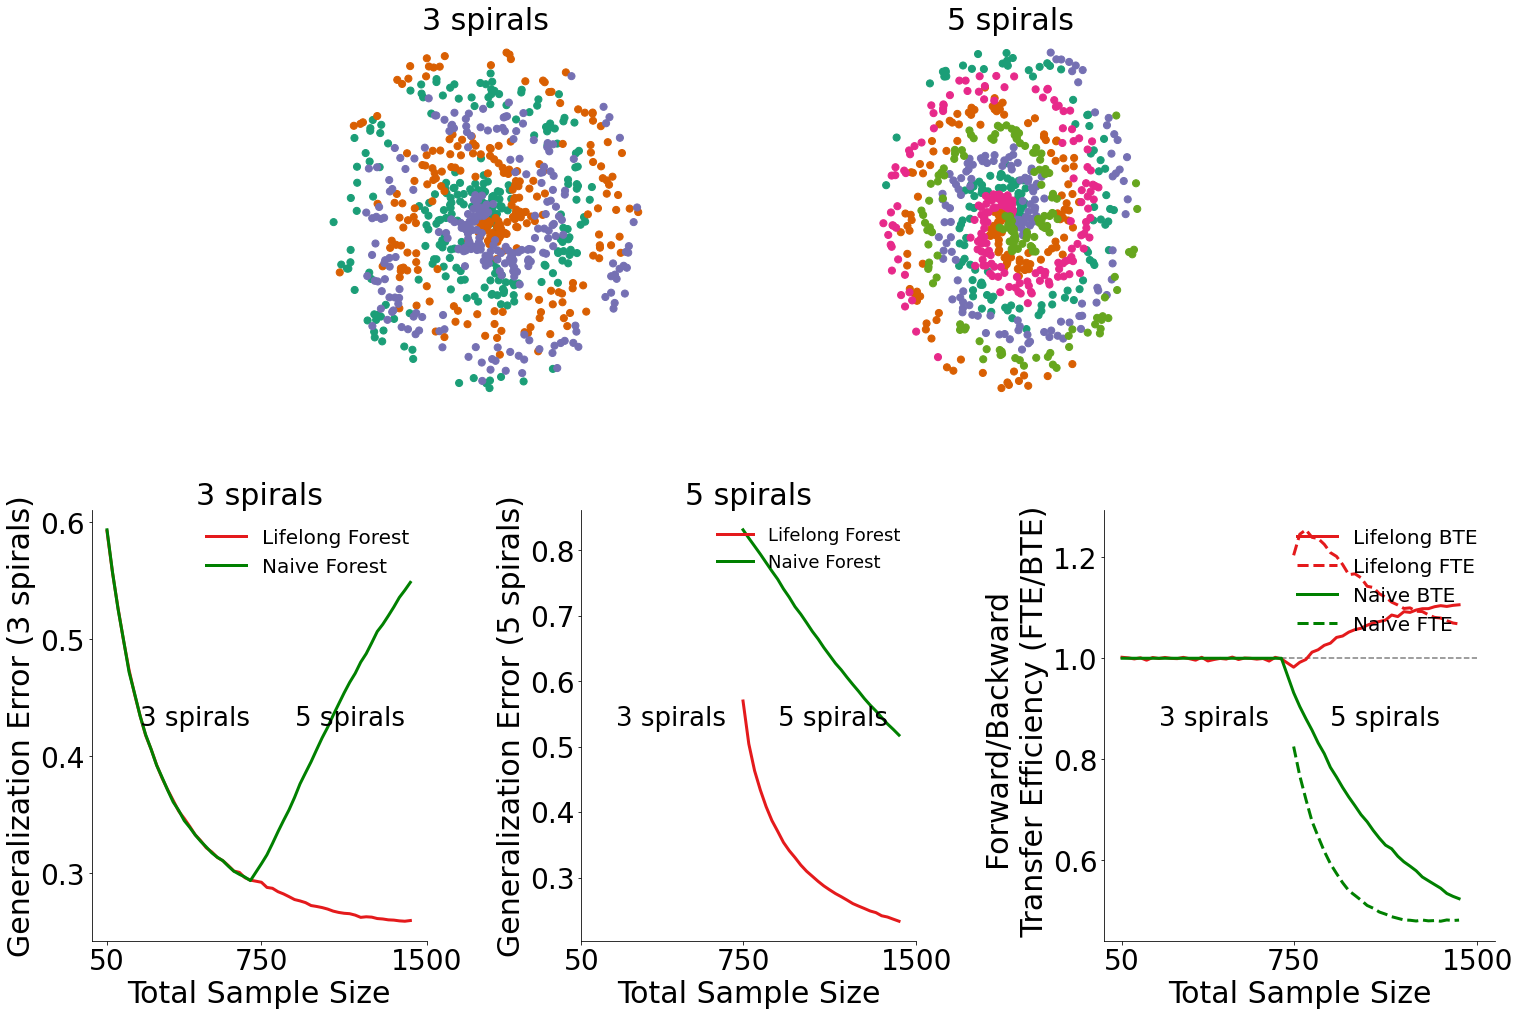

In [6]:
with open('mean_spiral.pickle','rb') as f:
    mean_error = pickle.load(f)

n1s = n_spiral3
n2s = n_spiral5

ns = np.concatenate((n1s, n2s + n1s[-1]))
ls=['-', '--']
algorithms = ['3 spirals Forest', '5 spirals Forest', 'Lifelong Forest', 'Naive Forest']


TASK1='3 spirals'
TASK2='5 spirals'

fontsize=30
labelsize=28

colors = sns.color_palette("Set1", n_colors = 5)

fig = plt.figure(constrained_layout=True,figsize=(21,14))
gs = fig.add_gridspec(14, 21)
ax1 = fig.add_subplot(gs[7:,:6])
ax1.plot(ns, mean_error[1], label=algorithms[2], c=colors[0], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
ax1.plot(ns, mean_error[4], label=algorithms[3], c='g', ls=ls[np.sum(1 > 1).astype(int)], lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK1), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=20, frameon=False)
#ax1.set_ylim(0.09, 0.21)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#ax1.set_yticks([0.5,0.15, 0.25])
ax1.set_xticks([50,750,1500])
#ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
ax1.set_title('3 spirals', fontsize=30)

right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(200, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

######################################

ax1 = fig.add_subplot(gs[7:,7:13])

ax1.plot(ns[len(n1s):], mean_error[3, len(n1s):], label=algorithms[2], c=colors[0], lw=3)
ax1.plot(ns[len(n1s):], mean_error[5, len(n1s):], label=algorithms[3], c='g', lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK2), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=18, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_xticks([50,750,1500])
#ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")


right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(200, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

ax1.set_title('5 spirals', fontsize=30)

#####################################
with open('mean_te_spiral.pickle','rb') as f:
    mean_te = pickle.load(f)

algorithms = ['Lifelong BTE', 'Lifelong FTE', 'Naive BTE', 'Naive FTE']

ax1 = fig.add_subplot(gs[7:,14:])

ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.plot(ns, mean_te[2], label=algorithms[2], c='g', ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[3, len(n1s):], label=algorithms[3], c='g', ls=ls[1], lw=3)

ax1.set_ylabel('Forward/Backward \n Transfer Efficiency (FTE/BTE)', fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=20, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_xticks([50,750,1500])
#ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.hlines(1, 50,1500, colors='gray', linestyles='dashed',linewidth=1.5)

ax1.text(200, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

colors = sns.color_palette('Dark2', n_colors=5)

X, Y = generate_spirals(750, 3, noise=0.8)
Z, W = generate_spirals(750, 5, noise=0.4)

ax = fig.add_subplot(gs[:6,4:10])
clr = [colors[i] for i in Y]
ax.scatter(X[:, 0], X[:, 1], c=clr, s=50)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('3 spirals', fontsize=30)

plt.tight_layout()
ax.axis('off')

colors = sns.color_palette('Dark2', n_colors=5)

ax = fig.add_subplot(gs[:6,11:16])
clr = [colors[i] for i in W]
ax.scatter(Z[:, 0], Z[:, 1], c=clr, s=50)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('5 spirals', fontsize=30)
ax.axis('off')

plt.savefig('plots/spiral_plot.pdf')